<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA0_51_encoding_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## rELA 0.51 encoding test
In this notebook file, the accuracy of parameter fitting when using {-1,1} instead of the conventional {0,1} is tested on data generated with the heat bath method.

## Setup

In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314928 sha256=99da642d4e2923559e1064efb313bc545c4b3d2f94d5b5e1a5b678de828be3e3
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2
rm: cannot remove 'rELA': No such file or directory
Cloning into 'rELA'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 397 (delta 103), reused 157 (delta 65), pack-reused 175
Receiving objects: 100% (397/397), 6.44 MiB | 28.30 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [2]:
#### installation error has been resolved ###
#%%R
# [for Google Colab]
# from v0.50, Due to errors in installing igraph and tidygraph
#system("add-apt-repository -y ppa:marutter/rrutter4.0")
#system("add-apt-repository -y ppa:c2d4u.team/c2d4u4.0+")
#system("add-apt-repository ppa:cran/v8")
#system("apt-get update")
#system("apt-get install libnode-dev")
#system("apt-get install r-cran-igraph r-cran-tidygraph")

In [3]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('plyr')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('plyr')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()       masks base::%||%()
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
%%R
# install rELA package
install.packages("rELA/rELA.v0.51_encoding_test.tar.gz")
library("rELA")

In [5]:
%%R
# for validation

#' @export
logmon.sy <- function(y, h, J) {
  # 行列のサイズを取得
  n <- nrow(y)
  m <- ncol(y)

  # 内部の計算を実行
  term <- - 2 * (h + y %*% J)
  result <- 1 / (1 + exp(term))

  return(result)
}

#' @export
OnestepHBS.sy <- function(y, logmo) {
  n <- nrow(y)
  m <- ncol(y)

  # Function to update one row of y
  update_row <- function(row_y, row_logmo) {
    position <- sample(1:m, 1)  # Randomly choose a position
    ne <- ifelse(runif(1) < row_logmo[position], 1, -1)  # Compare with logmo
    row_y[position] <- ne  # Update the chosen position
    return(row_y)
  }

  # Apply the update_row function to each row
  updated_y <- t(mapply(update_row, as.data.frame(t(y)), as.data.frame(t(logmo))))

  return(updated_y)
}

#' @export
HeatBath.sy <- function(steps, nproc, h, J) {
  # 初期状態の設定
  nn <- length(h)
  y <- array(-1, dim = c(nproc, nn))

  # 各ステップでの更新
  for (i in 1:steps) {
    logmo <- apply(y, 1, logmon.sy, h = h, J = J)
    y <- OnestepHBS.sy(y, t(logmo))
  }
  colnames(y) <- seq(length(h))
  return(y)
}

GradientDescent.sy <- function(data, maxit) {
  units <- ncol(data)
  tdata <- t(data)
  e <- 10^-8
  datalength <- nrow(data)
  tuples <- as.matrix(expand.grid(rep(list(c(-1,1)), units)))
  lt <- nrow(tuples)

  semp <- colMeans(data)
  ssemp <- t(data) %*% data / datalength * abs(diag(units) - 1)
  htt <- rep(0, units)
  jtt <- matrix(0, units, units)
  ttt <- 0
  while (ttt < maxit) {
    ht <- htt
    jt <- jtt
    e0 <- apply(tuples, 1, Energy, htt, jtt)
    en <- exp(-e0)
    etot <- sum(en)
    prb <- en / etot
    pt <- prb * tuples
    smod <- colSums(pt)
    ssmod <- (t(pt) %*% tuples) * abs(diag(units) - 1)
    dh <- 0.1 * ((semp + e) - (smod + e))
    dj <- 0.1 * ((ssemp + e) - (ssmod + e))
    htt <- ht + dh
    jtt <- jt + dj
    ttt <- ttt + 1
  }

  list(h.est = htt, j.est = jtt)
}

In [6]:
%%R
hb.paramgen(8) #種数を指定して実行すると検証用のパラメータ h.act, j.actをグローバルに定義する
data <- HeatBath.sy(500,512,h.act,j.act) #500ステップ×512個の並列の試行を行い、各試行の最後の状態のみ返す

In [7]:
%%R
sa <- runSA(ocmat=data, enmat=NULL, qth=10^-9, rep=128, threads=1, reporting=TRUE)
gd <- GradientDescent.sy(data, 10000)

Start parameter fitting:
SA: elapsed time 18.56 sec



In [8]:
%%R
c(cor(sa[1][[1]][,1], h.act), cor(gd[[1]], h.act), cor(c(sa[1][[1]][,-1]), c(j.act)), cor(c(gd[[2]]), c(j.act)))

[1] 0.9362999 0.8319013 0.8516708 0.8382737


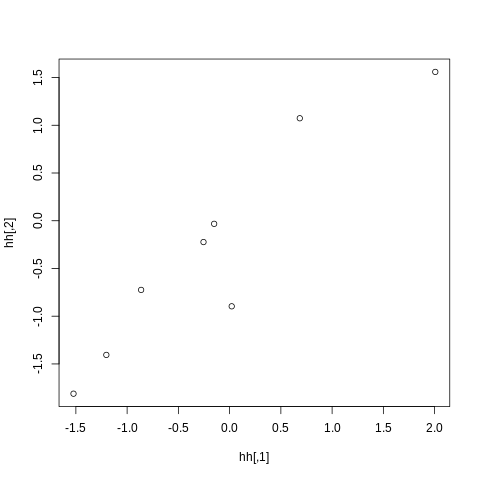

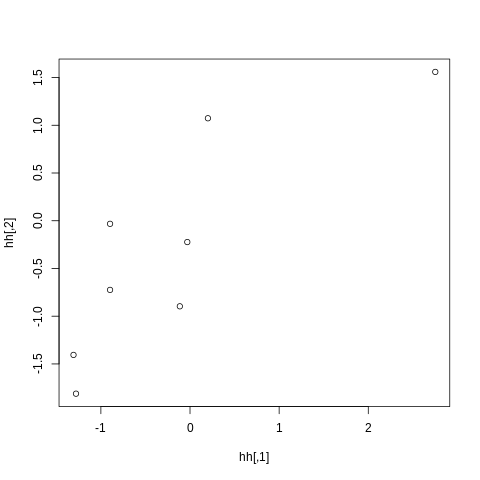

In [9]:
%%R
hh <- t(rbind(sa[1][[1]][,1], t(h.act)))
plot(hh)
hh <- t(rbind(gd[[1]], t(h.act)))
plot(hh)

In [12]:
%%R
start_time <- Sys.time()
install.packages("progressr")
library(progressr)
handlers(global = TRUE)
handlers("progress")


set.seed(4)
it <- 16
h.acts <- list()
j.acts <- list()
result <- with_progress({
  p <- progressor(along = 1:it)
  foreach(i=1:it, .combine='rbind') %do% {
    p(message = cat("="))
    hb.paramgen(8)
    h.acts <- c(h.acts, list(h.act))
    j.acts <- c(j.acts, list(j.act))
    data <- HeatBath.sy(500,512,h.act,j.act)
    sa <- runSA(ocmat=data, enmat=NULL, qth=10^-9, rep=128, threads=1, reporting=FALSE)
    gd <- GradientDescent.sy(data, 10000)
    c(cor(sa[1][[1]][,1], h.act), cor(gd[[1]], h.act), cor(c(sa[1][[1]][,-1]), c(j.act)), cor(c(gd[[2]]), c(j.act)))
    }
})

cat("\n")
colnames(result) <- c("sa.h","gd,h","sa.J","gd.J")
result <- data.frame(result)
column_means <- colMeans(result)
result <- rbind(result, mean = column_means)
print(result)
end_time <- Sys.time()
elapsed_time <- end_time - start_time
cat("elapsed time:", elapsed_time, "min. \n")

               sa.h      gd.h      sa.J      gd.J
result.1  0.6830511 0.7867889 0.4878647 0.8029522
result.2  0.8171710 0.8861904 0.7387663 0.7725268
result.3  0.9073541 0.9129988 0.8050587 0.9003586
result.4  0.6713423 0.8733156 0.4636202 0.6130263
result.5  0.9065226 0.8384294 0.8816915 0.8605105
result.6  0.6567676 0.9469793 0.7437849 0.8516907
result.7  0.6907080 0.7012212 0.8394219 0.8260105
result.8  0.8099667 0.8491055 0.8300004 0.8319361
result.9  0.9492323 0.9502100 0.9388392 0.9357151
result.10 0.8495019 0.8719613 0.8578478 0.8713283
result.11 0.8962373 0.9257045 0.7148310 0.7972706
result.12 0.9637877 0.9063841 0.8835280 0.8560147
result.13 0.9064978 0.8274160 0.9469828 0.9482631
result.14 0.8938833 0.7497389 0.7690523 0.7938517
result.15 0.6847417 0.7639558 0.8258464 0.8114524
result.16 0.7276133 0.6744153 0.6766780 0.7365198
mean      0.8133987 0.8415509 0.7752384 0.8255892
elapsed time: 26.40516 min. 
